In [78]:
import pandas as pd

data = pd.read_parquet("../data/dataset/reddit+shsyt/data.parquet").drop_duplicates(subset="id")

data["has_WoA"] = data.IOB.apply(lambda x: "B-WoA" in x)
data["has_Artist"] = data.IOB.apply(lambda x: "B-Artist" in x)
data = data[data.has_WoA | data.has_Artist]
data = data[data.IOB.apply(lambda x: "O" in x)]


/tmp/ipykernel_3643202/2773387360.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["notags"] = notags
/tmp/ipykernel_3643202/2773387360.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["frac_notags"] = frac_notags
/data/miniconda3/envs/torch21/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  da

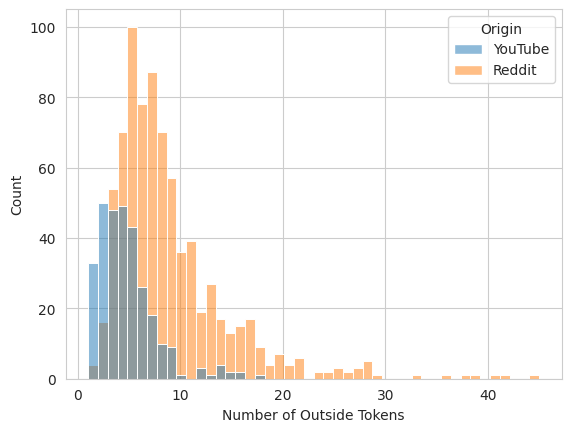

In [99]:
import seaborn as sns
import matplotlib.pyplot as plt

notags = data.IOB.apply(lambda x: len([t for t in x if t == "O"]))
frac_notags = notags / data.IOB.apply(len)
data["notags"] = notags
data["frac_notags"] = frac_notags

sns.histplot(data, x=data.notags, hue=data.Origin)
sns.set_style("whitegrid")
plt.xlabel("Number of Outside Tokens")
plt.savefig("../figures/hist_outside_tokens.pdf")
plt.show()



In [96]:
def process_iob_text(data, iob_col='IOB', text_col='TEXT'):
    def process_sequence(iob_tags, text_tokens):
        processed_iob = []
        processed_text = []
        current_class = None

        for iob, token in zip(iob_tags, text_tokens):
            if iob.startswith('B-'):
                current_class = iob[2:]  # Get the class name after 'B-'
                processed_iob.append(current_class)
                processed_text.append(f'[{current_class}]')
            elif iob.startswith('I-') and current_class:
                # Continue the current class, but skip it in output
                continue
            else:
                # It's an 'O' tag or something else
                current_class = None
                processed_iob.append('O')
                processed_text.append(token)
        
        return processed_iob, processed_text

    # Apply the process_sequence function row-wise
    data[['IOB_template', 'TEXT_template']] = data.apply(
        lambda row: process_sequence(row[iob_col], row[text_col]), axis=1, result_type='expand'
    )

    return data

data = process_iob_text(data)
data = data.drop_duplicates(subset=["TEXT_template"])


46                      [[Artist], &, [Artist], -, [WoA]]
79                                      [[WoA], -, [WoA]]
170                                  [[Artist], -, [WoA]]
249                                  [[WoA], -, [Artist]]
367     [spanish, harlem, -, [Artist], and, [Artist], ...
                              ...                        
2668    [looking, for, songs, similar, to, [WoA], (, [...
2672                                 [[WoA], |, [Artist]]
2676                    [songs, like, [Artist], [WoA], ?]
2677       [songs, /, artists, like, [WoA], by, [Artist]]
2680    [looking, for, an, album, or, ep, in, cassette...
Name: TEXT_template, Length: 1074, dtype: object

### Define functions for preprocessing, as in dataset

In [2]:
from typing import List
import sys
sys.path.append("../preprocessing")
from Processor import PerformerStringPreprocessor
from Utils import simplify_string, remove_bracket_with_one_content


def get_title_variations(s: str) -> List[str]:
    s = remove_bracket_with_one_content(s)
    l = s.split("/")
    l = [simplify_string(s) for s in l]
    return l

performer_processor = PerformerStringPreprocessor()

def get_performer_variations(s: str) -> List[str]:
    l = performer_processor.split_performers(s)
    l = [simplify_string(s) for s in l]
    l = performer_processor.article_preprocessing(l)
    return l

get_performer_variations("quentin tarantino feat. steven spielberg")


['quentin tarantino', 'steven spielberg']

### Loading additional info (Exoosure,Memorizationtest,Debut Artists)

#### Debut Artists

In [3]:
entity_dict = {}

data_debut = pd.read_json("../data/intermediate/debut_performers.jsonl", lines=True, orient="records")

list_postcutoff = []
for d in data_debut[["name", "release_title2"]].dropna().to_dict(orient="records"):
    d2 = {}
    d2["Artist"] = get_performer_variations(d["name"].lower())
    d2["WoA"] = get_title_variations(d["release_title2"].lower())
    list_postcutoff.append(d2)

entity_dict["post_cutoff"] = list_postcutoff
list_postcutoff[:5]

[{'Artist': ['kiradeer'], 'WoA': ['kiradeer']},
 {'Artist': ['the mackenzie dynamic', 'mackenzie dynamic'],
  'WoA': ['britparty']},
 {'Artist': ['ben keller'], 'WoA': ['fake you out']},
 {'Artist': ['dj durst'], 'WoA': ['dj durst early demos']},
 {'Artist': ['thistleblade'], 'WoA': ['forgotten north']}]

#### Memorization Test

In [4]:
import pandas as pd
import ast

data_shs = pd.read_json("../data/raw/shs100k_metadata.jsonl", lines=True, orient="records")
data_shs = data_shs[['work_id', 'perf_id','perf_title', 'perf_artist']]
data_shs.columns = pd.MultiIndex.from_product([[''], data_shs.columns])

data_memorization = pd.read_json("../data/intermediate/shs100k2_memorization.jsonl", lines=True, orient="records")

cols = []
for c in data_memorization.columns:
    new_c = ast.literal_eval(c)
    if new_c[1] == '':
        new_c = (new_c[1], new_c[0])
    cols.append(new_c)

data_memorization.columns = pd.MultiIndex.from_tuples(cols, names=["Model", ""])
data_memorization = pd.merge(data_memorization, data_shs, 
                             how="left", on=[("", "work_id"), ("", "perf_id")])



In [5]:
aw_cols = [c for c in data_memorization.columns if c[1].startswith("AW")]
aw_cols_related = [c for c in aw_cols if "Related" in c[1]]
aw_cols_correct = [c for c in aw_cols if "Correct" in c[1]]

def correctness(row):
    if row[aw_cols].T.sum() == 0:
        return "test_failed"
    elif row[aw_cols_correct].T.sum() >= 3:
        return "test_passed"
    elif row[aw_cols_correct].T.sum() == 0 and row[aw_cols_related].T.sum() > 0:
        return "test_min1_partly"
    elif row[aw_cols_correct].T.sum() > 0:
        return "test_min1"
    
data_memorization["Correctness"] = data_memorization.apply(correctness, axis=1)
data_memorization["Correctness"].value_counts()


Correctness
test_min1           4738
test_passed         3962
test_min1_partly    1022
test_failed          609
Name: count, dtype: int64

In [6]:

for ckey in data_memorization["Correctness"].unique():
    _ = data_memorization.loc[data_memorization.Correctness == ckey]
    entity_dict[ckey] = []
    for d in _[[("", "perf_artist"), ("", "perf_title")]].dropna().drop_duplicates().to_dict(
        orient="records"):
        d2 = {}
        d2["Artist"] = get_performer_variations(d[("","perf_artist")].lower())
        d2["WoA"] = get_title_variations(d[("","perf_title")].lower())
        entity_dict[ckey].append(d2)



#### Exposure

In [57]:
data_exposure = pd.read_json("../data/intermediate/shs100k2_exposure.jsonl", lines=True, orient="records")

exposure_threshold = 1.5

for ex in ["exposure_low", "exposure_high"]:

    entity_dict[ex] = []

    if ex == "exposure_low":
        mask = data_exposure.exposure_max < exposure_threshold
    else:
        mask = data_exposure.exposure_max >= exposure_threshold
    
    _ = (
        data_exposure.loc[mask, ["set_id", "name", "Entity"]]
        .drop_duplicates()
        .groupby(['set_id', 'Entity'], as_index=False)
        .agg({'name': lambda x: list(x)})
    )

    for d in _.pivot(index="set_id", columns="Entity", values="name").reset_index().to_dict(
        orient="records"):
        d2 = {}
        try:
            artist_variations = [get_performer_variations(s) for s in d["Artist"]]
            title_variations = [get_title_variations(s) for s in d["WoA"]]
        
            d2["Artist"] = [s for artist_variation in artist_variations for s in artist_variation]
            d2["WoA"] = [s for title_variation in title_variations for s in title_variation]

            entity_dict[ex].append(d2)
        except:
            pass



In [130]:
import random


def fill_template_with_entities(template, entity_dict):
    filled_text = []
    new_iob = []
    used_entities = {key: [] for key in entity_dict.keys()}

    for token in template:
        if isinstance(token, str) and token.startswith('[') and token.endswith(']'):
            placeholder = token.strip('[]')  # Extract entity class name

            if placeholder in entity_dict:
                # Get a random, unused entity from the list for this placeholder
                available_entities = list(set(entity_dict[placeholder]) - set(used_entities[placeholder]))
                if available_entities:
                    chosen_entity = random.choice(available_entities)
                    used_entities[placeholder].append(chosen_entity)
                else:
                    # If we've exhausted all unique entities, re-use from the list
                    chosen_entity = random.choice(entity_dict[placeholder])

                # Tokenize the chosen entity mention
                entity_tokens = chosen_entity.split()

                # Replace the placeholder with the tokenized entity
                filled_text.extend(entity_tokens)

                # Create IOB tags for each token in the entity mention
                new_iob.append(f'B-{placeholder}')
                new_iob.extend([f'I-{placeholder}'] * (len(entity_tokens) - 1))
            else:
                raise ValueError(f"Placeholder '{placeholder}' not found in entity_dict.")
        else:
            # It's a normal token, just append it with an 'O' tag
            filled_text.append(token)
            new_iob.append('O')

    return filled_text, new_iob

# sample example entity
cand_list = entity_dict["post_cutoff"]
ent = cand_list[random.randint(0, len(cand_list))]

# sample example template
template = data.TEXT_template.sample(1).item()

fill_template_with_entities(template=template, entity_dict=ent)


(['im',
  'looking',
  'for',
  'an',
  'album',
  'like',
  'radopan',
  '"',
  'unlock',
  'the',
  'box',
  '"',
  '.',
  'ideally',
  'instrumental',
  'only',
  '.'],
 ['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-Artist',
  'O',
  'B-WoA',
  'I-WoA',
  'I-WoA',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'])

In [131]:
data

,id,set_id,Origin,TEXT,IOB,subset,has_WoA,has_Artist,notags,frac_notags,Processed_IOB,Processed_TEXT,IOB_template,TEXT_template
46,21_L1-t3YvFH40,21.0,YouTube,"[gladys, knight, &, the, pips, -, yesterday]","[B-Artist, I-Artist, O, B-Artist, I-Artist, O,...",4,True,True,2,0.285714,"[Artist, O, Artist, O, WoA]","[[Artist], &, [Artist], -, [WoA]]","[Artist, O, Artist, O, WoA]","[[Artist], &, [Artist], -, [WoA]]"
79,21_4SE8UvqaSWQ,21.0,YouTube,"[hooked, on, the, beatles, -, the, end]","[B-WoA, I-WoA, I-WoA, I-WoA, O, B-WoA, I-WoA]",4,True,False,1,0.142857,"[WoA, O, WoA]","[[WoA], -, [WoA]]","[WoA, O, WoA]","[[WoA], -, [WoA]]"
170,58_hQz-aZH-ozU,58.0,YouTube,"[juan, rozoff, -, plaisir, d, amour]","[B-Artist, I-Artist, O, B-WoA, I-WoA, I-WoA]",1,True,True,1,0.166667,"[Artist, O, WoA]","[[Artist], -, [WoA]]","[Artist, O, WoA]","[[Artist], -, [WoA]]"
249,58_-cbPbDQhoyg,58.0,YouTube,"[i, cant, help, falling, in, love, -, enrico, ...","[B-WoA, I-WoA, I-WoA, I-WoA, I-WoA, I-WoA, O, ...",1,True,True,1,0.111111,"[WoA, O, Artist]","[[WoA], -, [Artist]]","[WoA, O, Artist]","[[WoA], -, [Artist]]"
367,81_kRssJvqEfzY,81.0,YouTube,"[spanish, harlem, -, alan, haven, and, tony, c...","[O, O, O, B-Artist, I-Artist, O, B-Artist, I-A...",1,True,True,5,0.333333,"[O, O, O, Artist, O, Artist, O, WoA]","[spanish, harlem, -, [Artist], and, [Artist], ...","[O, O, O, Artist, O, Artist, O, WoA]","[spanish, harlem, -, [Artist], and, [Artist], ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2668,dataset4_739,12661.0,Reddit,"[looking, for, songs, similar, to, florida, ki...","[O, O, O, O, O, B-WoA, I-WoA, O, B-Artist, I-A...",2,True,True,7,0.583333,"[O, O, O, O, O, WoA, O, Artist, O]","[looking, for, songs, similar, to, [WoA], (, [...","[O, O, O, O, O, WoA, O, Artist, O]","[looking, for, songs, similar, to, [WoA], (, [..."
2672,dataset4_743,12665.0,Reddit,"[gently, wind, |, joshua, speedy]","[B-WoA, I-WoA, O, B-Artist, I-Artist]",1,True,True,1,0.200000,"[WoA, O, Artist]","[[WoA], |, [Artist]]","[WoA, O, Artist]","[[WoA], |, [Artist]]"
2676,dataset4_746,12669.0,Reddit,"[songs, like, sub, urbams, cradle, ?]","[O, O, B-Artist, I-Artist, B-WoA, O]",5,True,True,3,0.500000,"[O, O, Artist, WoA, O]","[songs, like, [Artist], [WoA], ?]","[O, O, Artist, WoA, O]","[songs, like, [Artist], [WoA], ?]"
2677,dataset4_747,12670.0,Reddit,"[songs, /, artists, like, quarter, past, midni...","[O, O, O, O, B-WoA, I-WoA, I-WoA, O, B-Artist]",1,True,True,5,0.555556,"[O, O, O, O, WoA, O, Artist]","[songs, /, artists, like, [WoA], by, [Artist]]","[O, O, O, O, WoA, O, Artist]","[songs, /, artists, like, [WoA], by, [Artist]]"


In [10]:
import random

def perturb_characters(text, num_chars_to_perturb):
    """
    Perturb a specific number of characters in the input text.
    
    Args:
        text (str): The original text to perturb.
        num_chars_to_perturb (int): The number of characters to perturb.
        
    Returns:
        str: The perturbed text.
    """
    characters = list(text)
    text_length = len(characters)

    if num_chars_to_perturb > text_length:
        num_chars_to_perturb = text_length

    for _ in range(num_chars_to_perturb):
        perturbation_type = random.choice(["substitution", "deletion", "insertion"])
        index = random.randint(0, len(characters) - 1)
        
        if perturbation_type == "substitution":
            # Replace the character with a random one
            characters[index] = random.choice("abcdefghijklmnopqrstuvwxyz-./_=")
        elif perturbation_type == "deletion" and len(characters) > 1:
            # Remove the character
            characters.pop(index)
        elif perturbation_type == "insertion":
            # Insert a random character
            characters.insert(index, random.choice("abcdefghijklmnopqrstuvwxyz-./="))
    
    return ''.join(characters)


def perturb_tokens(text, perturbation_strength=0.1):
    """
    Perturb tokens in the input text.
    
    Args:
        text (str): The original text to perturb.
        perturbation_strength (float): The proportion of tokens to perturb (0 to 1).
        
    Returns:
        str: The perturbed text.
    """
    tokens = text.split()
    num_perturbations = int(len(tokens) * perturbation_strength)
    
    for _ in range(num_perturbations):
        perturbation_type = random.choice(["substitution", "deletion", "shuffle"])
        index = random.randint(0, len(tokens) - 1)
        
        if perturbation_type == "substitution":
            # Replace the token with a random one (for simplicity, replacing with "RANDOM" token)
            tokens[index] = "RANDOM"
        elif perturbation_type == "deletion" and len(tokens) > 1:
            # Remove the token
            tokens.pop(index)
        elif perturbation_type == "shuffle" and len(tokens) > 1:
            # Shuffle the token with another random token
            swap_index = random.randint(0, len(tokens) - 1)
            tokens[index], tokens[swap_index] = tokens[swap_index], tokens[index]
    
    return ' '.join(tokens)



In [11]:
perturb_characters("The beatles", num_chars_to_perturb=1)


'Txe beatles'

In [12]:
# Example usage
text = "This is an example text."
perturbed_text = perturb_tokens(text, perturbation_strength=0.2)
print(perturbed_text)



This is an text.
